Consider the deterministic repressilator described via the Michaelis-Menten equations in Loinger, et al

• Construct a Petri net representation of the system for case 
    (i) with mRNA (i.e. corre-sponding to Eq. 1)  
    (ii) without mRNA (i.e. corresponding to Eq.2)
    
• Solve the ODEs for case (i) numerically with parameters:
    k=dm= 1 and dp=gp.
    
• Plot phase portraits showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3] 

• Repeat the same exercise for case (ii)

Background (Longier&Biham2007 ; Elowitz2000)

The genetic repressilator circuit consists of three transcription factors, or repressors, which negatively regulate each other in a cyclic manner. This circuit was synthetically constructed on plasmids in Escherichia coli and was found to exhibit oscillations in the concentrations of the three repressors. 

### Background (Longier&Biham2007 ; Elowitz2000)

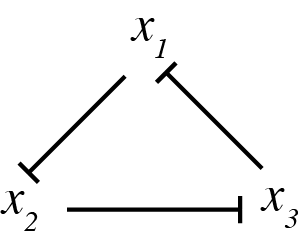


### Represillator Circuit as a Synthetic Biological Clock
 
A ____|  B      high  | low   |  high  |  low   |  high  |  low   |   high
      |               |       |        |        |        |        |
      
      
      ------------------------------------------------------------------------
 
 
B ____|  C     high   | high  |  low   |  high  |  low   |  high  |   low
      |               |       |        |        |        |        |
      
      
      -----------1-------2--------3--------4--------5--------6---------7--
      
C ____|  A      high  | low   |  high  |  low   |  high  |  low   |   high
      |               |       |        |        |        |        |
      
 
Summarily ____   C   -->  B  -->   A -->    C   occurs at certain conditions
                     

Background (Longier&Biham2007 ; Elowitz2000)

The repressilator is found to oscillate with period t ~ 150 mins. The oscillations are noisy and irregular. Recent theoretical work has shown that stochastic effects maybe responsible for noisy operation in natural gene-expression networks [2] The role of fluctuations is enhanced due to the discrete nature of the transcription factors and their binding sites, which may appear in low copy numbers [1] Therefore, the repressilator circuit cannot be fully analyzed using deterministic methods such as rate equations. Here we perform stochastic analysis of the repressilator circuit using the master equation and Monte Carlo simulations.

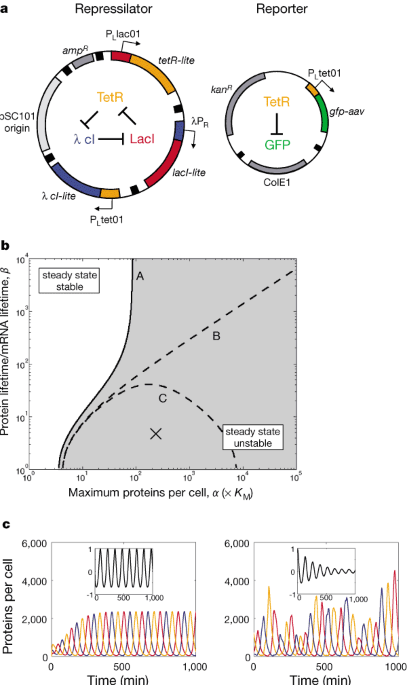

In [1]:
import scipy, scipy.integrate, scipy.optimize, pylab, copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import PowerNorm
import matplotlib.pylab as plb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#  Repressilator with RNA

In [4]:
# <codecell>
class HillRepressilator:
    def __init__(self, gamma_m, gamma_p, del_m, del_p, n, k, y0):
        """
        Initiate a HillRepressilator (i.e., a Repressilator where the
        protein-DNA interaction is subsumed in a simple Hill function).
        Instance parameters are initialized based on the input parameters
        Also store the bare parameters (K_m, K_p, T, K_b) so that you can
        convert from scaled times and concentrations back to bare times
        and concentrations if desired.
        """
        self.gamma_m = 10**gamma_m
        self.gamma_p = 10**gamma_p
        self.del_m=del_m
        self.del_p=10**del_p
        self.n = n
        self.k = k
        self.y0_6 = y0

    @staticmethod
    def dydt(y, t, log_gm, log_gp, del_m, log_dp, n, k):
        """Define the right-hand-side of the Repressilator equations
        for use with scipy.integrate.odeint.  Since this needs to be called
        as if it were a standalone function, and not an instance method
        (which would implicitly assume the first argument is the instance
        self), we declare this as a staticmethod so that self is not passed
        as an implicit argument.  Alternatively, one could define dydt
        outside the HillRepressilator class, but this is cleaner."""
        
        """
    Returns 6-array of (dm_1/dt, dm_2/dt, dm_3/dt, dx_1/dt, dx_2/dt, dx_3/dt)
    """
        m_1, m_2, m_3, x_1, x_2, x_3 = y
        
        gamma_m = 10**log_gm
        gamma_p = 10**log_gp
        del_p=10**log_dp
    
        return np.array(
            [
                gamma_m/(1+(k*(x_3**n))) - del_m*m_1,
                gamma_m/(1+(k*(x_1**n))) - del_m*m_2,
                gamma_m/(1+(k*(x_2**n))) - del_m*m_3,
                gamma_p *m_1 - del_p*x_1,
                gamma_p *m_2 - del_p*x_2,
                gamma_p *m_3 - del_p*x_3
            ]
        )
           
    def run(self, y0, T, nT, params):
        """
        run(self, )
        Run the Repressilator for the specified amount of time T, returning
        output for a specified array of times.  Store the trajectory returned
        by odeint in the instance variable self.traj, concatenating the result
        to the existing self.traj if a previous trajectory had been created.
        """
        self.args = params
        self.time = np.linspace(0, T, nT)
        self.x = scipy.integrate.odeint(self.dydt, self.y0_6, self.time, self.args)
        m1, m2, m3, x1, x2, x3 = self.x.transpose()
        self.traj = self.x.transpose()
        
        return [self.time, self.traj]
               
    def plot(self, time, soln, show_proteins, show_mRNAs):
        """Plot the trajectory of the Repressilator, optionally showing
        either the protein concentrations or the mRNA concentrations,
        in either dimensionless or rescaled units."""
        
        number = 6
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
        
        m1, m2, m3, x1, x2, x3 = soln
        
        
        if show_proteins:
            plt.plot(time, x1, linewidth=2, color=colors[0], label="x1")
            plt.plot(time, x2, linewidth=2, color=colors[2], label="x2")
            plt.plot(time, x3, linewidth=2, color=colors[4], label="x3")
            plt.legend(loc='best')
            plt.show()
            
        if show_mRNAs:
            plt.plot(time, m1, linewidth=2, color=colors[1], label="m1")
            plt.plot(time, m2, linewidth=2, color=colors[3], label="m2")
            plt.plot(time, m3, linewidth=2, color=colors[5], label="m3")
            plt.legend(loc='best')
            plt.show()
            
    def plot_phase_diagram(self, var1, var2, varName1, varName2,col):
        # Solve for species concentrations    
        self.var1 = var1
        self.var2 = var2
        plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
        plt.ylabel(varName1)
        plt.xlabel(varName2)
        return plt

<ipython-input-2-db48bfc742da>:80: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x1, linewidth=2, color=colors[0], label="x1")
<ipython-input-2-db48bfc742da>:81: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x2, linewidth=2, color=colors[2], label="x2")
<ipython-input-2-db48bfc742da>:82: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x3, linewidth=2, color=colors[4], label="x3")


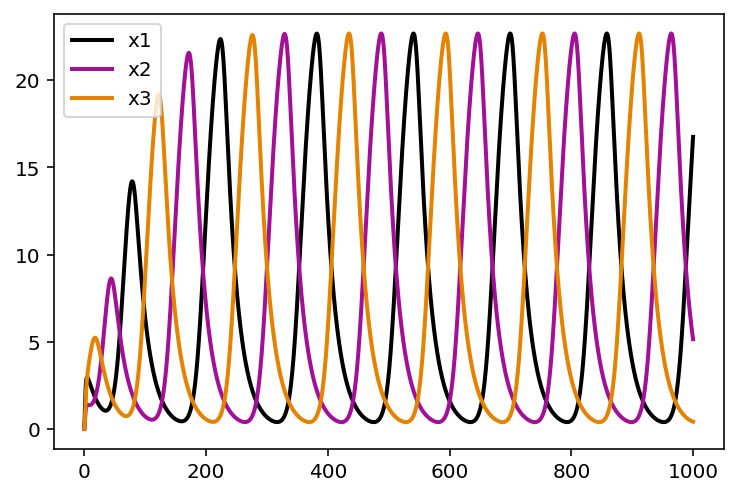

<ipython-input-2-db48bfc742da>:87: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, m1, linewidth=2, color=colors[1], label="m1")
<ipython-input-2-db48bfc742da>:88: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, m2, linewidth=2, color=colors[3], label="m2")
<ipython-input-2-db48bfc742da>:89: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, m3, linewidth=2, color=colors[5], label="m3")


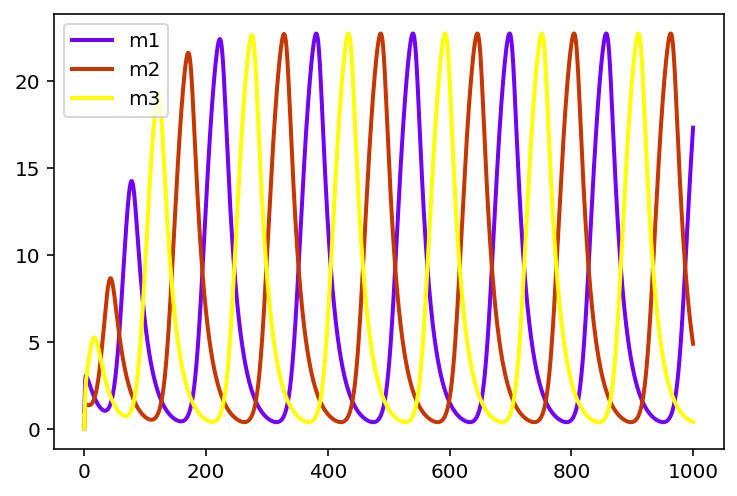

In [3]:
n=3
k=1
d_m=0.05
log_dp=np.log10(1)   #dp = 10^(log_dp)
log_gp=np.log10(1)   #gp = 10^(log_gp)
log_gm=np.log10(1.5)   #gm = 10^(log_gm)

y0=[1,0,0,0,0,0]       #initial condition (m1,m2,m3,x1,x2,x3)

# initialize HillRepressilator object repsl with above ppts.
repls = HillRepressilator(log_gm, log_gp, d_m, log_dp, n, k, y0)

# Set parameters for running simulation unchanged and solve odes
params = (log_gm, log_gp, d_m, log_dp, n, k)
[tsolve, soln] = HillRepressilator.run(repls, y0, 1000, 10000, params)

# Plot system dynamics
HillRepressilator.plot(repls, tsolve, soln, "True", "True")


# Trajectories showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3] 


<ipython-input-4-db48bfc742da>:97: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
<ipython-input-4-db48bfc742da>:97: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
<ipython-input-4-db48bfc742da>:97: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
<ipython-input-4-db48bfc742da>:97: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
<ipython-input-4-db48bfc742da>:97: MatplotlibDeprecationWarning: Case-insensitive properties

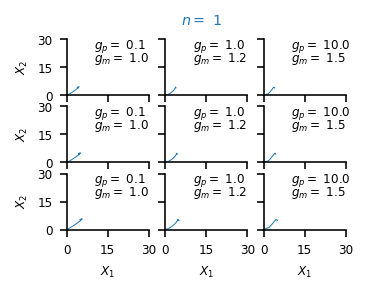

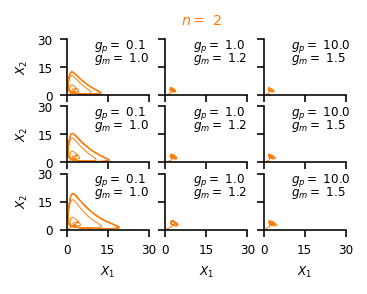

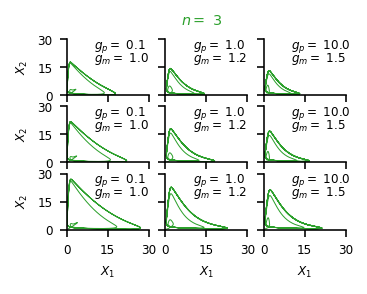

In [5]:
n = np.array([1,2,3])
k=1
d_m=0.05
y0=[1,0,0,0,0,0]

log_dp=np.linspace(np.log10(0.1),1,3)
log_gp=np.linspace(np.log10(0.1),1,3)
log_gm=np.linspace(np.log10(1),np.log10(1.5),3)

for l in range(len(n)):
    repls3x1 = []
    repls3x2 = []
    repls3x3 = []
    if n[l]==1:
        col='C0'
    elif n[l]==2:
        col='C1'
    else:
        col='C2'
    for i in range(len(log_gm)):
        for j in range(len(log_gp)):
            repls = HillRepressilator(log_gm[i], log_gp[j], d_m, log_gp[j], n[l], k, y0)
            params = (log_gm[i], log_gp[j], d_m, log_dp[j], n[l], k)
            [tsolve, soln] = HillRepressilator.run(repls, y0, 1000, 1000, params)
            m1, m2, m3, x1, x2, x3 = soln
            repls3x1.append(x1)
            repls3x3.append(x3)

    fontsiz=6
    f=plt.figure(figsize=(2.5,1.75))
    plt.rcParams['font.size'] = fontsiz
    for i in range(9):
        plb.subplot(3,3,i+1)
        plt.xlim([0,30])
        plt.xticks([0,15,30])
        plt.ylim([0,30])    
        plt.yticks([0,15,30])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.text(10,25,r'$g_p=$ %1.1f' %(10**log_gp[i%3]))
        plt.text(10,18,r'$g_m=$ %1.1f' %(10**log_gm[i%3]))       
        HillRepressilator.plot_phase_diagram(repls, repls3x1[i], repls3x3[i]," ", " ",col)
    ax_list = f.axes
    no_y_list=np.array([1,2,4,5,7,8])
    plt.suptitle(r'$n=$ %d' %(n[l]),color=col)
    for i in range(6):
        ax_list[i].set_xticklabels([])
        ax_list[no_y_list[i]].set_yticklabels([])
    x_list=np.array([6,7,8])
    y_list=np.array([0,3,6])
    for i in range(3):
        ax_list[x_list[i]].set_xlabel(r'$X_1$')
        ax_list[y_list[i]].set_ylabel(r'$X_2$')
    if n[l]==1:
        f.savefig('4.3.oscillations_n1.jpg', format='jpg', dpi=500,bbox_inches="tight") 
    elif n[l]==2:
        f.savefig('4.3.oscillations_n2.jpg', format='jpg', dpi=500,bbox_inches="tight") 
    else:
        f.savefig('4.3.oscillations_n3.jpg', format='jpg', dpi=500,bbox_inches="tight") 


# Repressilator without RNA

In [6]:
# <codecell>
class HillRepressilatorX:
    def __init__(self, gamma_p, gamma_m, del_p, del_m, n, k, y0):
        """
        Initiate a HillRepressilator (i.e., a Repressilator where the
        protein-DNA interaction is subsumed in a simple Hill function).
        Instance parameters are initialized based on the input parameters
        Also store the bare parameters (K_m, K_p, T, K_b) so that you can
        convert from scaled times and concentrations back to bare times
        and concentrations if desired.
        """
        
        self.gamma_p = 10**gamma_p
        self.del_p=10**del_p
        self.gamma_m = 10**gamma_m
        self.del_m= del_m
        self.n = n
        self.k = k
        self.y0_3 = y0

    @staticmethod
    def dydt(y, t, log_gp,log_gm,log_dp,del_m, n, k):
        """Define the right-hand-side of the Repressilator equations
        for use with scipy.integrate.odeint.  Since this needs to be called
        as if it were a standalone function, and not an instance method
        (which would implicitly assume the first argument is the instance
        self), we declare this as a staticmethod so that self is not passed
        as an implicit argument.  Alternatively, one could define dydt
        outside the HillRepressilator class, but this is cleaner."""
        
        """
    Returns 3-array of (dx_1/dt, dx_2/dt, dx_3/dt)
    """

        gamma_p = 10**log_gp
        gamma_m = 10**log_gm
        del_p = 10**log_dp
        
        g= gamma_p*gamma_m/del_m
        x_1, x_2, x_3 = y
    
        return np.array(
            [
                g/(1+(k*(x_3**n))) - del_p*x_1,
                g/(1+(k*(x_1**n))) - del_p*x_2,
                g/(1+(k*(x_2**n))) - del_p*x_3
            ]
        )  
        
    def run(self, y0, T, nT, params):
        """
        run(self, )
        Run the Repressilator for the specified amount of time T, returning
        output for a specified array of times.  Store the trajectory returned
        by odeint in the instance variable self.traj, concatenating the result
        to the existing self.traj if a previous trajectory had been created.
        """
        self.args = params
        self.time = np.linspace(0, T, nT)
        self.x = scipy.integrate.odeint(self.dydt, self.y0_3, self.time, self.args)
        x1, x2, x3 = self.x.transpose()
        self.traj = self.x.transpose()
        return [self.time, self.traj]
           

    def plot(self, time, soln):
        """Plot the trajectory of the Repressilator, optionally showing
        either the protein concentrations or the mRNA concentrations,
        in either dimensionless or rescaled units."""
        
        number = 6
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]
        
        x1, x2, x3 = soln
        plt.plot(time, x1, linewidth=2, color=colors[0], label="x1")
        plt.plot(time, x2, linewidth=2, color=colors[2], label="x2")
        plt.plot(time, x3, linewidth=2, color=colors[4], label="x3")
        plt.legend(loc='best')
        plt.show()
 
    def plot_phase_diagram(self, var1, var2, varName1, varName2,col):
        # Solve for species concentrations           
        self.var1 = var1
        self.var2 = var2
        plt.plot(self.var1, self.var2, linewidth=0.5,color=col)
        plt.ylabel(varName1)
        plt.xlabel(varName2)
        return plt

<ipython-input-6-1315efd234bb>:76: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x1, LineWidth=2, color=colors[0], label="x1")
<ipython-input-6-1315efd234bb>:77: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x2, LineWidth=2, color=colors[2], label="x2")
<ipython-input-6-1315efd234bb>:78: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(time, x3, LineWidth=2, color=colors[4], label="x3")


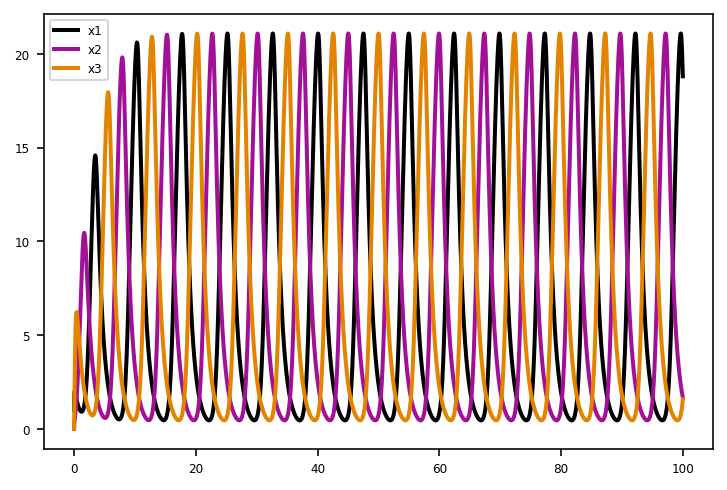

In [7]:
n=3
k=1
d_m=0.05
log_dp=np.log10(1)
log_gp=np.log10(1)
log_gm=np.log10(1.5)
y0=[1,0,0]
replsX = HillRepressilatorX(log_gp,log_gm, log_dp,d_m, n, k, y0)
params = (log_gp,log_gm, log_dp,d_m, n, k)
[tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
HillRepressilatorX.plot(replsX, tsolve, soln)

## Trajectories showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3]

<ipython-input-6-1315efd234bb>:86: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, lineWidth=0.5,color=col)
<ipython-input-6-1315efd234bb>:86: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, lineWidth=0.5,color=col)
<ipython-input-6-1315efd234bb>:86: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, lineWidth=0.5,color=col)
<ipython-input-6-1315efd234bb>:86: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(self.var1, self.var2, lineWidth=0.5,color=col)
<ipython-input-6-1315efd234bb>:86: MatplotlibDeprecationWarning: Case-insensitive properties

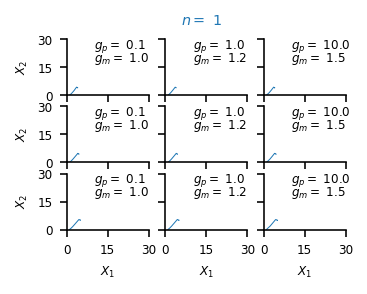

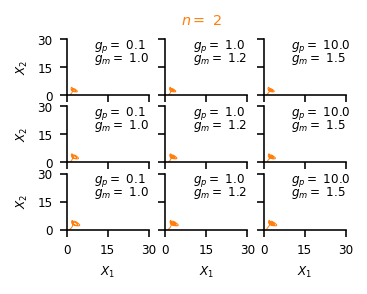

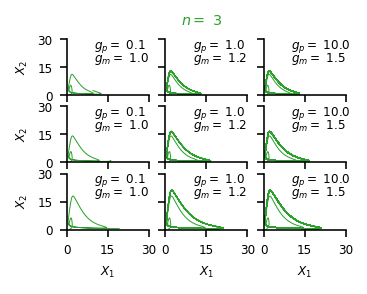

In [8]:
n = np.array([1,2,3])
k=1
d_m=0.05
y0=[1,0,0]

log_dp=np.linspace(np.log10(0.1),1,3)
log_gp=np.linspace(np.log10(0.1),1,3)
log_gm=np.linspace(np.log10(1),np.log10(1.5),3)

for l in range(len(n)):
    replsX3x1 = []
    replsX3x2 = []
    replsX3x3 = []
    if n[l]==1:
        col='C0'
    elif n[l]==2:
        col='C1'
    else:
        col='C2'
    for i in range(len(log_gm)):
        for j in range(len(log_gp)):
            replsX = HillRepressilatorX(log_gp[j],log_gm[i],log_dp[j],d_m, n[l], k, y0)
            params = (log_gp[j],log_gm[i],log_dp[j],d_m, n[l], k)
            [tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
            x1, x2, x3 = soln
            replsX3x1.append(x1)
            replsX3x3.append(x3)

    fontsiz=6
    f=plt.figure(figsize=(2.5,1.75))
    plt.rcParams['font.size'] = fontsiz
    for i in range(9):
        plb.subplot(3,3,i+1)
        plt.xlim([0,30])
        plt.xticks([0,15,30])
        plt.ylim([0,30])    
        plt.yticks([0,15,30])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.text(10,25,r'$g_p=$ %1.1f' %(10**log_gp[i%3]))
        plt.text(10,18,r'$g_m=$ %1.1f' %(10**log_gm[i%3]))       
        HillRepressilatorX.plot_phase_diagram(replsX, replsX3x1[i], replsX3x3[i],' ',' ',col)
    ax_list = f.axes
    no_y_list=np.array([1,2,4,5,7,8])
    plt.suptitle(r'$n=$ %d' %(n[l]),color=col)
    for i in range(6):
        ax_list[i].set_xticklabels([])
        ax_list[no_y_list[i]].set_yticklabels([])
    x_list=np.array([6,7,8])
    y_list=np.array([0,3,6])
    for i in range(3):
        ax_list[x_list[i]].set_xlabel(r'$X_1$')
        ax_list[y_list[i]].set_ylabel(r'$X_2$')
    if n[l]==1:
        f.savefig('4.3.rna_free_n1.jpg', format='jpg', dpi=500,bbox_inches="tight") 
    elif n[l]==2:
        f.savefig('4.3.rna_free_n2.jpg', format='jpg', dpi=500,bbox_inches="tight") 
    else:
        f.savefig('4.3.rna_free_n3.jpg', format='jpg', dpi=500,bbox_inches="tight") 
